# Preprocessing Data : 

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from collections import Counter
import pycountry_convert as pc
import numpy as np

### Convert duration of all movies to minute  

In [2]:
df = pd.read_csv("imdb.csv")

def convert_duration(duration):
    parts = duration.split()
    total_minutes = 0
    for part in parts:
        if 'h' in part:
            total_minutes += int(part.rstrip('h')) * 60
        elif 'm' in part:
            total_minutes += int(part.rstrip('m'))
    return total_minutes

df['Duration'] = df['Duration'].apply(convert_duration)

print(df['Duration'])


0       142
1       152
2       148
3       139
4       142
       ... 
6189    112
6190     87
6191     92
6192     91
6193     95
Name: Duration, Length: 6194, dtype: int64


In [3]:
df['Meta Score'] = df['Meta Score'].replace([np.inf, -np.inf], np.nan)
df.dropna(subset=['Meta Score'], inplace=True)
df['Meta Score'] = df['Meta Score'].astype(int)

### Number of vote preprocessing

In [4]:
def convert_votes(votes_str):
    if 'K' in votes_str:
        return int(float(votes_str.rstrip('K')) * 1000)
    elif 'M' in votes_str:
        return int(float(votes_str.rstrip('M')) * 1000000)
    else:
        return int(votes_str)

df['Number of Votes'] = df['Number of Votes'].apply(convert_votes)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5662 entries, 0 to 6193
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5662 non-null   int64  
 1   Title              5662 non-null   object 
 2   Release Year       5662 non-null   int64  
 3   Age Restriction    5662 non-null   object 
 4   Duration           5662 non-null   int64  
 5   Genre              5662 non-null   object 
 6   Rating             5662 non-null   float64
 7   Number of Votes    5662 non-null   int64  
 8   Meta Score         5662 non-null   int32  
 9   Language           5660 non-null   object 
 10  Country of Origin  5662 non-null   object 
 11  Companies          5662 non-null   object 
 12  Budget             4852 non-null   object 
 13  Gross (worldwide)  5365 non-null   object 
dtypes: float64(1), int32(1), int64(4), object(8)
memory usage: 641.4+ KB


## Budget Preprocessing

In the dataset most of the budgets movie has been written in USD. We want to convert all of the budjets to USD to have a unique numerical variable.   

### Gross world wide feature

For clean this feature we should:

 - Remove $ sign.
 - Clean the budget value:
    Every 3 digits of budget has been seperated with ','. for example $200,500,000. It must convert to $20050000 

In [6]:
def convert_currency(value):
    if isinstance(value, str) and value.startswith('$'):
        return int(value.replace('$', '').replace(',', ''))
    else:
        return value

df['Gross (worldwide)'] = df['Gross (worldwide)'].apply(convert_currency)

### Budget Feature

The budget feature has the problem to So we must clean the budget value.

All of the budgets are not in USD. The 'Budget' column contains various currency symbols. In this block of code we print them.

In [7]:
def extract_prefix(budget):
    match = re.match(r'([^\d]+)', str(budget).strip())
    if match:
        return match.group(1)
    return None


df['Prefix'] = df['Budget'].apply(extract_prefix)
unique_prefixes = df['Prefix'].dropna().unique()

unique_prefixes_list = unique_prefixes.tolist()
print(unique_prefixes_list)

['$', 'FRF\xa0', '€', '£', 'R$', '₹', '¥', 'nan', 'DKK\xa0', 'DEM\xa0', '₩', 'CA$', 'RUR\xa0', 'ITL\xa0', 'CN¥', 'NOK\xa0', 'ATS\xa0', 'A$', 'SEK\xa0', 'NZ$', 'BEF\xa0', 'THB\xa0', 'SGD\xa0', 'HUF\xa0']


These prefixes appear to be international currency symbols and codes. The presence of non-breaking space characters (\xa0) indicates that some of the prefixes include a space character that might need to be cleaned up.

To convert the currency budget to USD, we'll need to use exchange rates for each currency.

Here’s a step-by-step approach:

1. **Define exchange rates** for each currency symbol.
2. **Extract the numeric part** and **currency prefix**.
3. **Convert the values** to USD using the exchange rates.
4. **Create a new column** with the converted value

In [8]:
exchange_rates = {
    '$': 1.0,       # USD to USD 
    'FRF': 0.17,    # French Franc to USD
    '€': 1.1,       # Euro to USD
    '£': 1.3,       # British Pound to USD
    'R$': 0.2,      # Brazilian Real to USD
    '₹': 0.012,     # Indian Rupee to USD
    '¥': 0.0073,    # Japanese Yen to USD
    'DKK': 0.15,    # Danish Krone to USD
    'DEM': 0.51,    # German Mark to USD
    '₩': 0.00079,   # South Korean Won to USD
    'CA$': 0.78,    # Canadian Dollar to USD
    'RUR': 0.014,   # Russian Ruble to USD
    'ITL': 0.00058, # Italian Lira to USD
    'CN¥': 0.16,    # Chinese Yuan to USD
    'NOK': 0.1,     # Norwegian Krone to USD
    'ATS': 0.08,    # Austrian Schilling to USD
    'A$': 0.76,     # Australian Dollar to USD
    'SEK': 0.12,    # Swedish Krona to USD
    'BEF': 0.027,   # Belgian Franc to USD
    'THB': 0.031,   # Thai Baht to USD
    'NZ$': 0.70,    # New Zealand Dollar to USD
    'SGD': 0.74,    # Singapore Dollar to USD
    'HUF': 0.0034   # Hungarian Forint to USD
}

def extract_currency_and_amount(budget):
    budget = str(budget).replace('\xa0', ' ').strip()
    match = re.match(r'([^\d\s]+)?\s?(\d+)', budget)
    if match:
        prefix = match.group(1)
        amount = match.group(2)
        return prefix, float(amount)
    return None, None

def convert_to_usd(prefix, amount):
    if prefix in exchange_rates:
        return amount * exchange_rates[prefix]
    return amount

df['Prefix'], df['Amount'] = zip(*df['Budget'].apply(extract_currency_and_amount))
df['Budget'] = df.apply(lambda row: convert_to_usd(row['Prefix'], row['Amount']), axis=1)
df = df.drop(columns=['Prefix', 'Amount'])

print(df['Budget'])

0        25.0
1       185.0
2       160.0
3        63.0
4        55.0
        ...  
6188     30.0
6189     36.0
6190      NaN
6191      NaN
6193      NaN
Name: Budget, Length: 5662, dtype: float64


### Reduce Budget and gross Digits
These numbers in the budget and gross are too big, compromising its readability. Let's convert the unit of the budget and gross columns from $ to million $ first.

In [9]:
df['Budget'] = df['Budget']/1000000
df['Gross (worldwide)'] = df['Gross (worldwide)']/1000000

df[['Budget', 'Gross (worldwide)']].describe()

,Budget,Gross (worldwide)
count,4.852000e+03,5365.000000
mean,5.518391e-05,115.029475
std,1.022259e-04,200.289217
min,1.160000e-09,0.000126
25%,1.100000e-05,12.793213
50%,2.600000e-05,45.916769
75%,6.000000e-05,127.869379
max,1.248000e-03,2923.706026


In [10]:
print(df['Budget'])

0       0.000025
1       0.000185
2       0.000160
3       0.000063
4       0.000055
          ...   
6188    0.000030
6189    0.000036
6190         NaN
6191         NaN
6193         NaN
Name: Budget, Length: 5662, dtype: float64


### Adding profit feature

The profit of a movie is a crusial measure for investor. In this notebook There are many analyzes to see the attributes of beneficial movies.

After cleaning the budget and world wide gross feature we can easily calculate the profit of movie. It contains the difference of the two columns: gross and budget.

In [11]:
df['profit'] = df['Gross (worldwide)'] - df['Budget']
df.head()
df.describe()   

,Unnamed: 0,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide),profit
count,5662.000000,5662.000000,5662.000000,5662.000000,5.662000e+03,5662.000000,4.852000e+03,5365.000000,4726.000000
mean,2965.281703,2004.314553,110.814906,6.684846,1.542932e+05,58.886436,5.518391e-05,115.029475,128.360130
std,1775.002602,14.300104,19.992447,0.915993,2.170102e+05,17.906990,1.022259e-04,200.289217,209.517263
min,0.000000,1950.000000,57.000000,1.500000,2.600000e+04,1.000000,1.160000e-09,0.000126,-0.000513
25%,1429.250000,1998.000000,97.000000,6.200000,4.400000e+04,46.000000,1.100000e-05,12.793213,19.001969
50%,2894.500000,2007.000000,107.000000,6.700000,8.000000e+04,59.000000,2.600000e-05,45.916769,55.418665
75%,4465.750000,2015.000000,121.000000,7.300000,1.690000e+05,72.000000,6.000000e-05,127.869379,148.040147
max,6193.000000,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,1.248000e-03,2923.706026,2923.705789


## Companies Feature

In [12]:
all_companies = df['Companies'].str.split('~').explode()
company_counts = Counter(all_companies)
top_companies = company_counts.most_common(25)
top_df = pd.DataFrame(top_companies, columns=['Company', 'Frequency'])
print(top_df)
print(top_df['Frequency'].sum() / df.shape[0])

                      Company  Frequency
0                Warner Bros.        393
1          Universal Pictures        374
2          Paramount Pictures        329
3           Columbia Pictures        327
4       Twentieth Century Fox        228
5        Walt Disney Pictures        191
6             New Line Cinema        177
7   Metro-Goldwyn-Mayer (MGM)        122
8         Touchstone Pictures        113
9            Relativity Media        111
10    New Regency Productions        109
11        Dreamworks Pictures        109
12            Lionsgate Films         97
13  Village Roadshow Pictures         84
14                    Miramax         80
15       Summit Entertainment         72
16                    Netflix         72
17                StudioCanal         66
18             Focus Features         62
19       Amblin Entertainment         60
20    Legendary Entertainment         58
21          Fox 2000 Pictures         57
22                Screen Gems         57
23   Fox Searchl

In [13]:
df.describe()

,Unnamed: 0,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide),profit
count,5662.000000,5662.000000,5662.000000,5662.000000,5.662000e+03,5662.000000,4.852000e+03,5365.000000,4726.000000
mean,2965.281703,2004.314553,110.814906,6.684846,1.542932e+05,58.886436,5.518391e-05,115.029475,128.360130
std,1775.002602,14.300104,19.992447,0.915993,2.170102e+05,17.906990,1.022259e-04,200.289217,209.517263
min,0.000000,1950.000000,57.000000,1.500000,2.600000e+04,1.000000,1.160000e-09,0.000126,-0.000513
25%,1429.250000,1998.000000,97.000000,6.200000,4.400000e+04,46.000000,1.100000e-05,12.793213,19.001969
50%,2894.500000,2007.000000,107.000000,6.700000,8.000000e+04,59.000000,2.600000e-05,45.916769,55.418665
75%,4465.750000,2015.000000,121.000000,7.300000,1.690000e+05,72.000000,6.000000e-05,127.869379,148.040147
max,6193.000000,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,1.248000e-03,2923.706026,2923.705789


In [14]:
df.reset_index(inplace=True)
df.drop(['Unnamed: 0', 'index'], axis = 1, inplace=True)
df.to_csv("preprocessed_imdb.csv", index=False)

# EDA : 

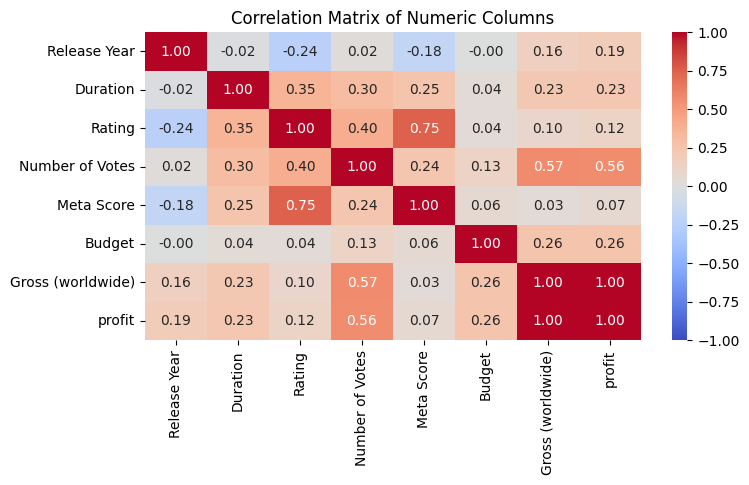

In [15]:
df = pd.read_csv("preprocessed_imdb.csv")
numeric_columns = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, vmin=-1, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

#### Observations
This plot defines the correlation between features. By analysing this graph we can clearly understand 
- The proft , gross , budget and number of votes are highly dependable.
- The Rating and Meta score are highly dapendable.

### Profit and budget

By plotting the scatter plot and histogram of profit and budget we are going to visualize the relation of these features.

First we sort the dataset by profit in descending order.
 

In [16]:
sotredprofit_movies = df.sort_values(by='profit' , ascending=False)
sotredprofit_movies.head()

,Title,Release Year,Age Restriction,Duration,Genre,Rating,Number of Votes,Meta Score,Language,Country of Origin,Companies,Budget,Gross (worldwide),profit
29,Avatar,2009,PG-13,162,Action~Adventure~Fantasy,7.9,1400000,83,English~Spanish,United States,Twentieth Century Fox~Dune Entertainment~Light...,0.000237,2923.706026,2923.705789
36,Avengers: Endgame,2019,PG-13,181,Action~Adventure~Drama,8.4,1300000,78,English~Japanese~Xhosa~German,United States,Marvel Studios~Walt Disney Pictures,0.000356,2799.439100,2799.438744
325,Avatar: The Way of Water,2022,PG-13,192,Action~Adventure~Fantasy,7.6,493000,67,English,United States,20th Century Studios~TSG Entertainment~Lightst...,0.000350,2320.250281,2320.249931
34,Titanic,1997,PG-13,194,Drama~Romance,7.9,1300000,75,English~Swedish~Italian~French,United States~Mexico,Twentieth Century Fox~Paramount Pictures~Light...,0.000200,2264.750694,2264.750494
73,Star Wars: Episode VII - The Force Awakens,2015,PG-13,138,Action~Adventure~Sci-Fi,7.8,973000,80,English,United States,Lucasfilm~Bad Robot,0.000245,2071.310218,2071.309973


<Figure size 800x600 with 0 Axes>

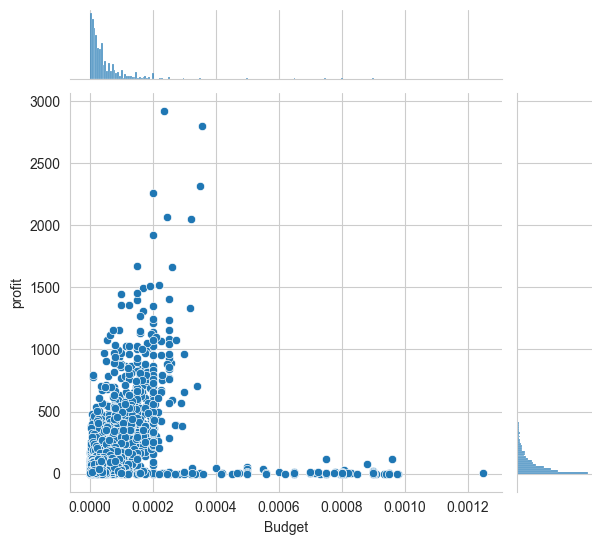

In [17]:
sns.set_style('whitegrid')

plt.figure(figsize=[8,6])
h= sns.jointplot(x='Budget', y='profit' , data=df)
plt.subplots_adjust(top=0.9)
plt.show()

#### Observations

- Most of movies were profitable.
- Both Budget and profit are slightly skewd to right which means most of the movies had positive profit.
- There is a positive relation between profit and budget.

### Profitable movies.

A new feature is added named isProfitable that is for recognizing the movies that has positive or negative profit.The positive profit is defined when the profid is greater than the double of our budget.

In [18]:
df['isProfitable'] = df['profit'] > (df['Budget']*2)

### Profitable and unprofitable movies properties

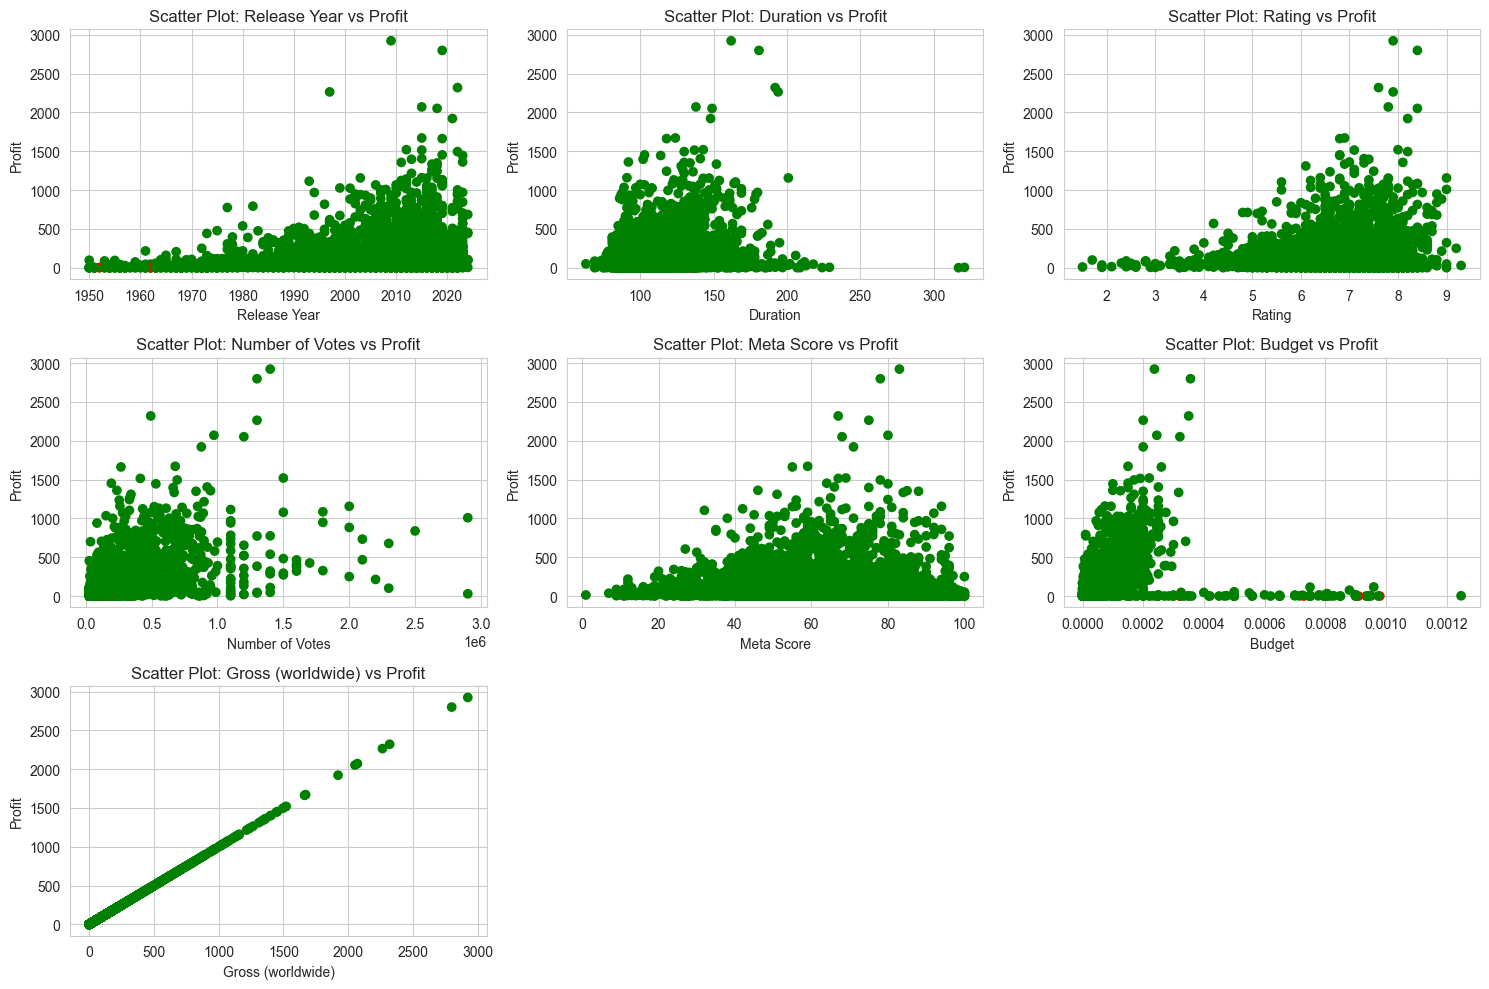

In [19]:
features = ['Release Year', 'Duration', 'Rating', 'Number of Votes', 'Meta Score', 'Budget', 'Gross (worldwide)']


plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    plt.scatter(df[feature], df['profit'], c=df['isProfitable'].map({True: 'green', False: 'red'}))
    plt.xlabel(feature)
    plt.ylabel('Profit')
    plt.title(f'Scatter Plot: {feature} vs Profit')

plt.tight_layout()
plt.show()

### Top 10 Companies with most profit 

### Top Generes with most profit

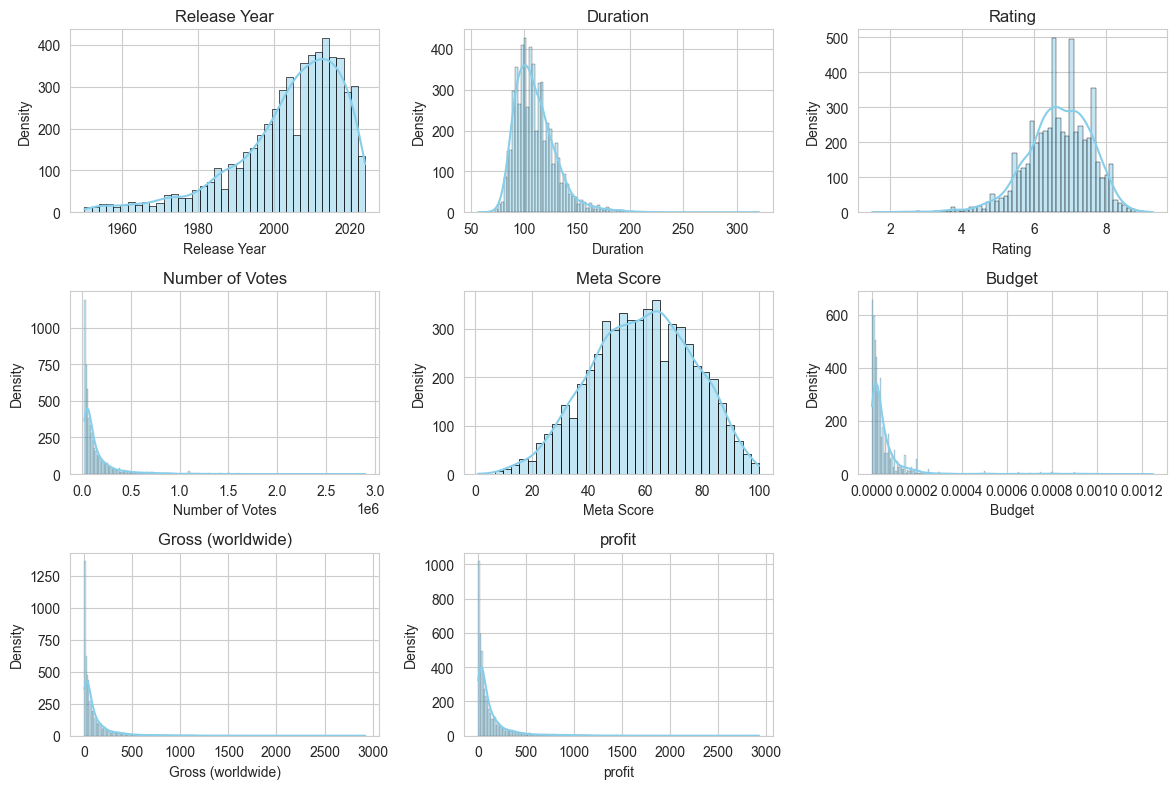

In [20]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=df, x=col, kde=True, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

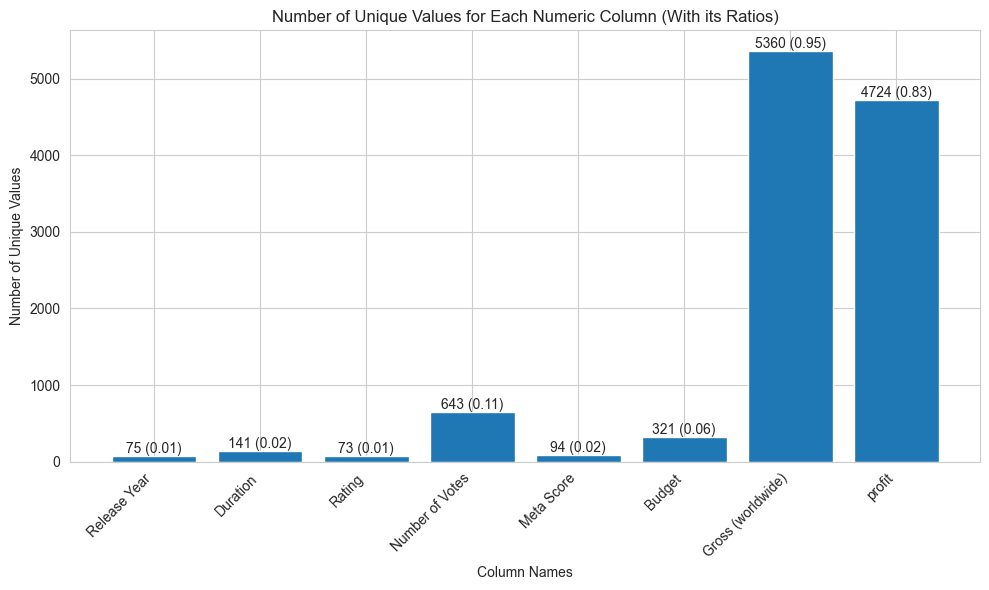

In [21]:
column_names = []
unique_value_counts = []
ratios = []

for column in numeric_columns.columns:
    column_names.append(column)
    unique_count = len(df[column].value_counts())
    unique_value_counts.append(unique_count)
    ratio = unique_count / len(df)
    ratios.append(ratio)

plt.figure(figsize=(10, 6))
bars = plt.bar(column_names, unique_value_counts)
plt.xlabel('Column Names')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Values for Each Numeric Column (With its Ratios)')
plt.xticks(rotation=45, ha='right')

for bar, count, ratio in zip(bars, unique_value_counts, ratios):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count} ({ratio:.2f})', ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Top 15 movies with highest profit

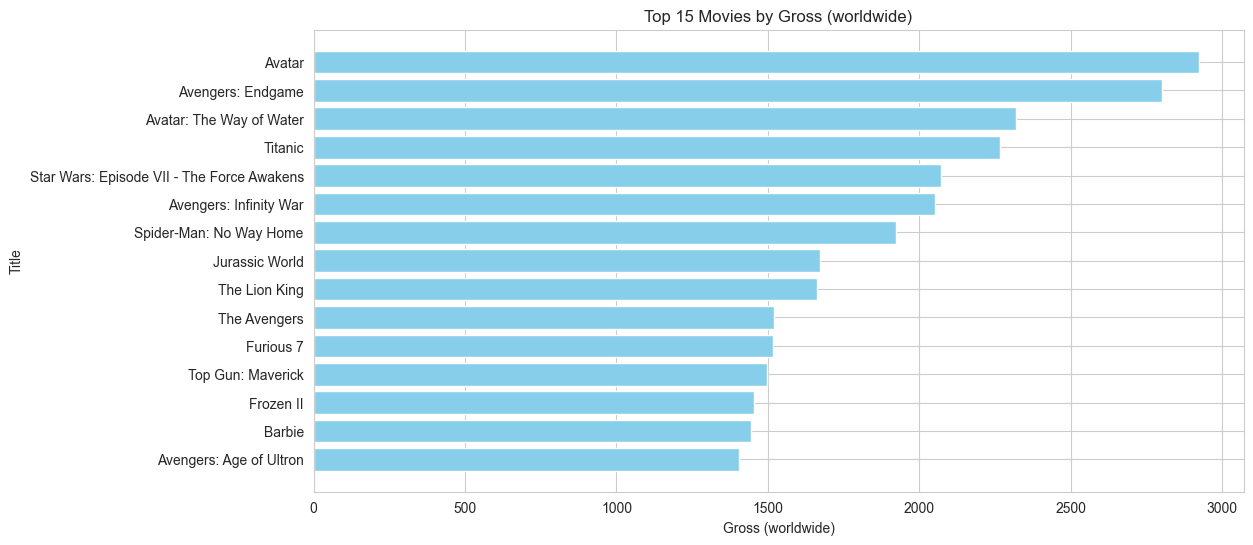

In [22]:

df = df.sort_values(by=['Gross (worldwide)'], ascending=False)
top_15 = df.head(15)

plt.figure(figsize=(12,6))
plt.barh(top_15['Title'], top_15['Gross (worldwide)'], color='skyblue')
plt.xlabel('Gross (worldwide)')
plt.ylabel('Title')
plt.title('Top 15 Movies by Gross (worldwide)')
plt.gca().invert_yaxis() 

plt.show()


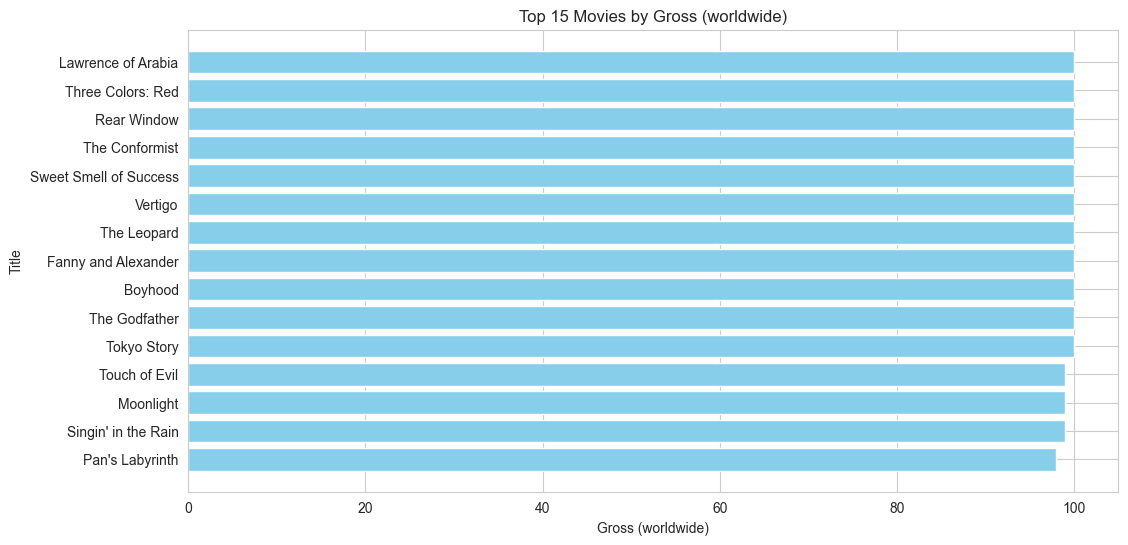

In [23]:
df = df.sort_values(by=['Meta Score'], ascending=False)
top_15 = df.head(15)

plt.figure(figsize=(12,6))
plt.barh(top_15['Title'], top_15['Meta Score'], color='skyblue')
plt.xlabel('Meta Score')
plt.ylabel('Title')
plt.title('Top 15 Movies by Meta Score')
plt.gca().invert_yaxis() 

plt.show()

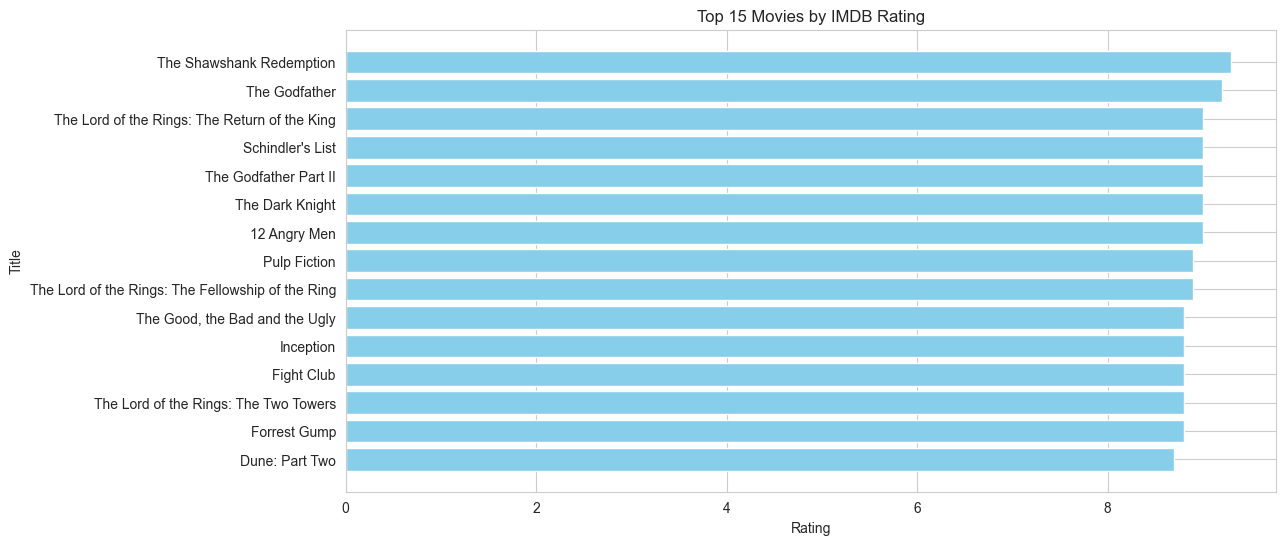

In [24]:
df = df.sort_values(by=['Rating'], ascending=False)
top_15 = df.head(15)

plt.figure(figsize=(12,6))
plt.barh(top_15['Title'], top_15['Rating'], color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Title')
plt.title('Top 15 Movies by IMDB Rating')
plt.gca().invert_yaxis() 

plt.show()

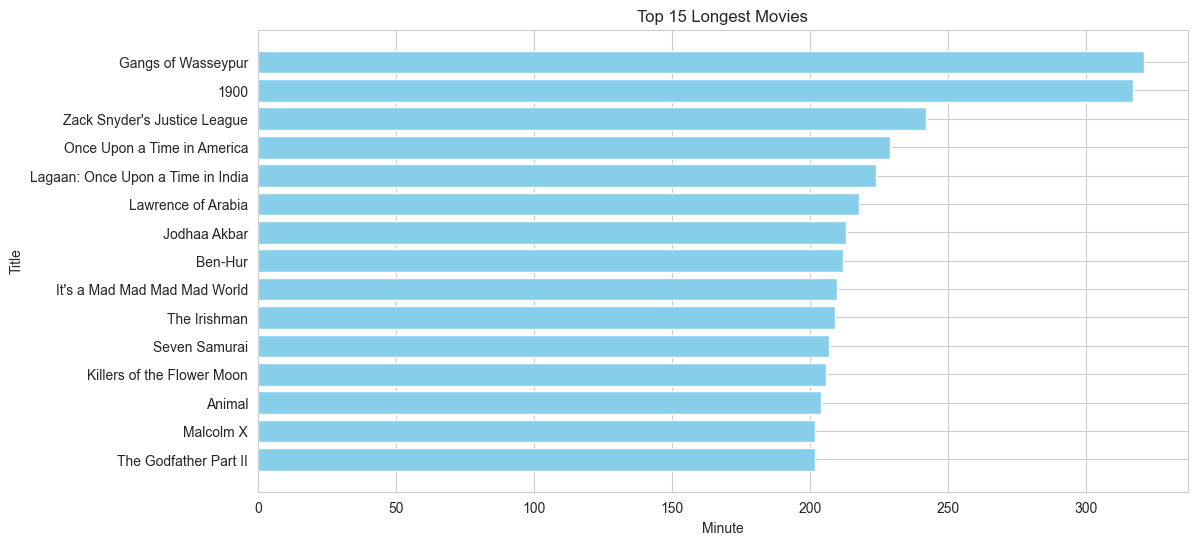

In [25]:
df = df.sort_values(by=['Duration'], ascending=False)
top_15 = df.head(15)

plt.figure(figsize=(12,6))
plt.barh(top_15['Title'], top_15['Duration'], color='skyblue')
plt.xlabel('Minute')
plt.ylabel('Title')
plt.title('Top 15 Longest Movies')
plt.gca().invert_yaxis() 

plt.show()

In [35]:
temp_df = df.copy()

temp_df['Genre'] = temp_df['Genre'].str.split('~')
df_genres = temp_df.explode('Genre')
genres_list = df_genres['Genre'].unique()

print(genres_list)

['Action' 'Comedy' 'Crime' 'Drama' 'History' 'Adventure' 'Fantasy'
 'Musical' 'Sport' 'Biography' 'Western' 'Romance' 'War' 'Family' 'Horror'
 'Thriller' 'Mystery' 'Sci-Fi' 'Music' 'Documentary' 'Animation'
 'Film-Noir' 'News']


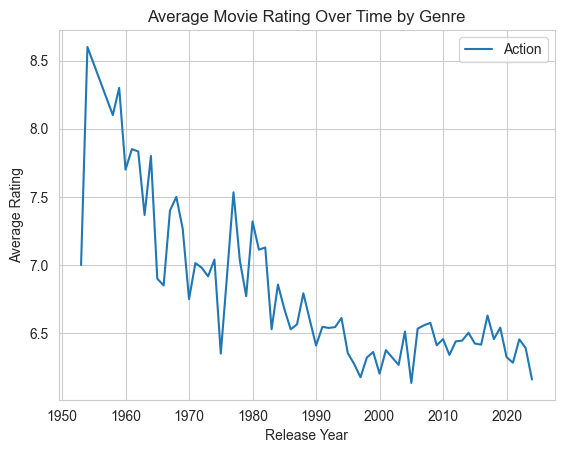

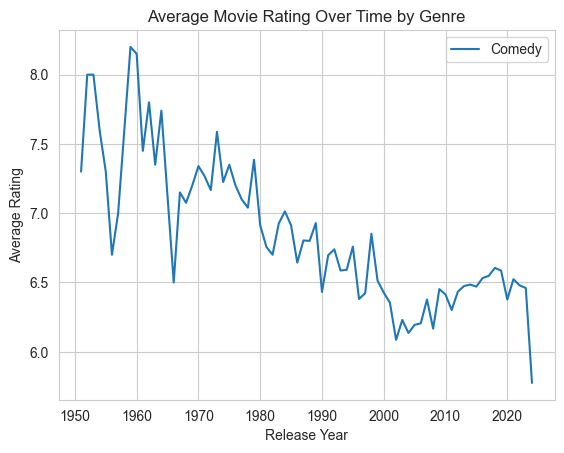

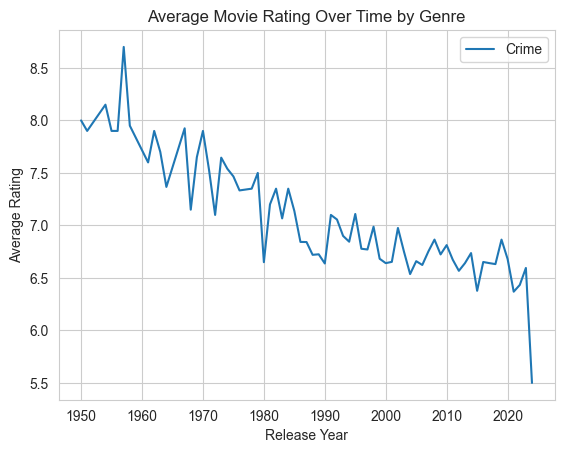

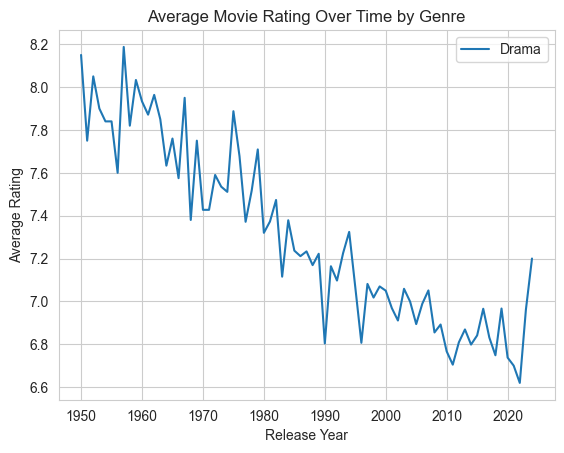

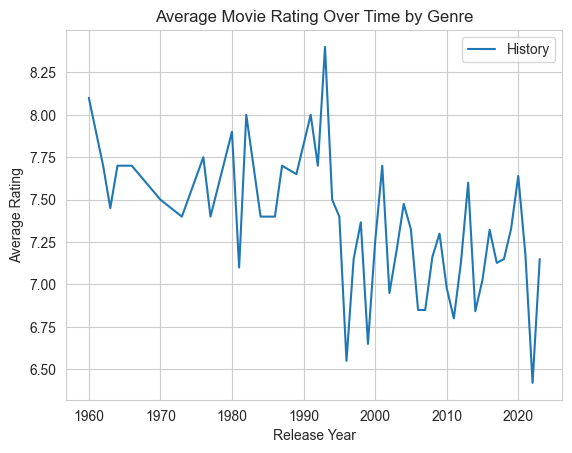

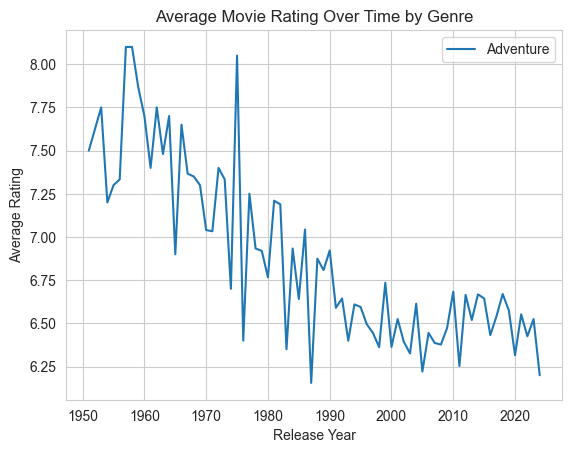

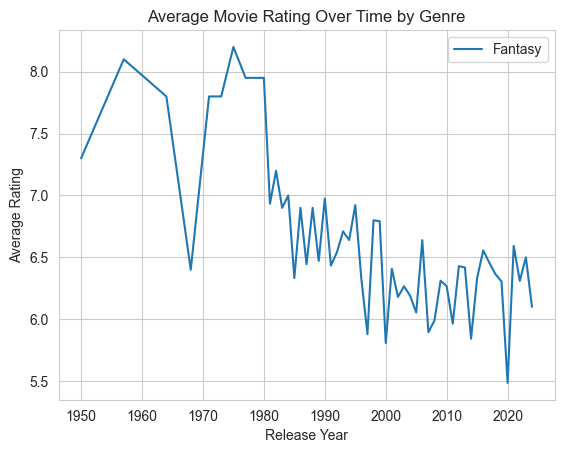

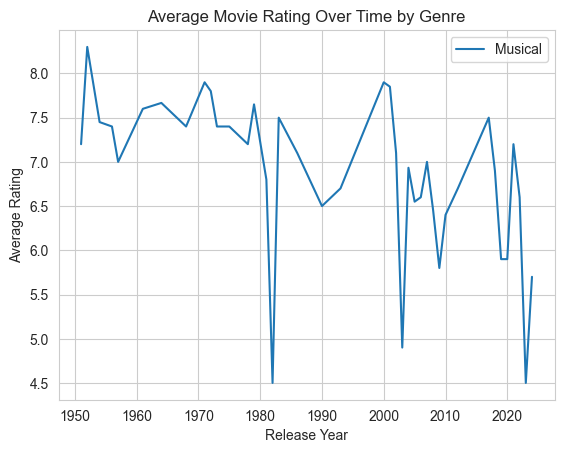

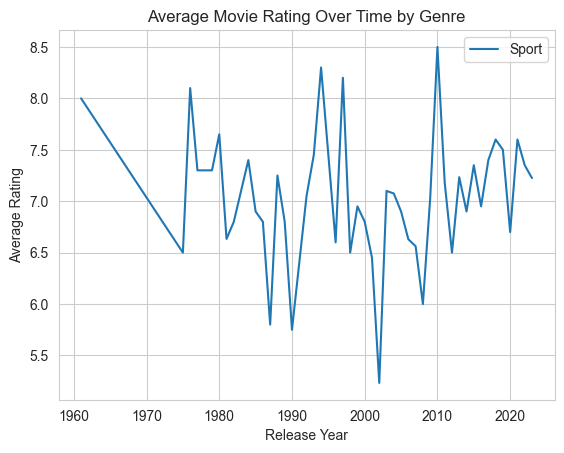

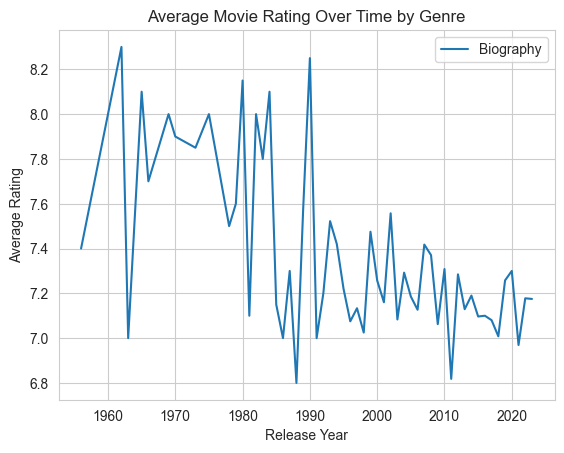

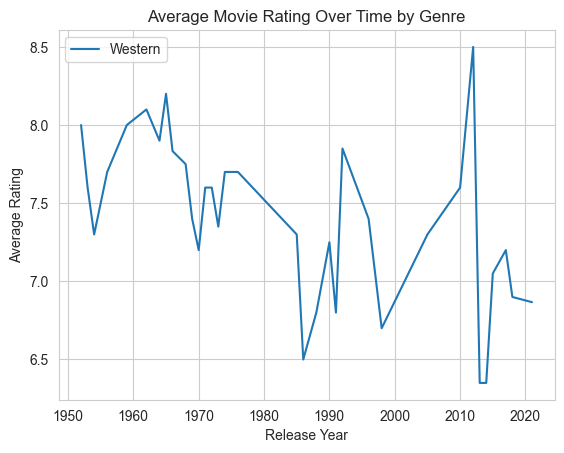

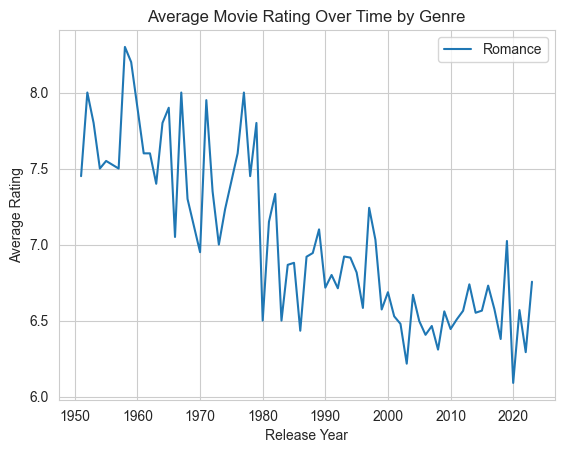

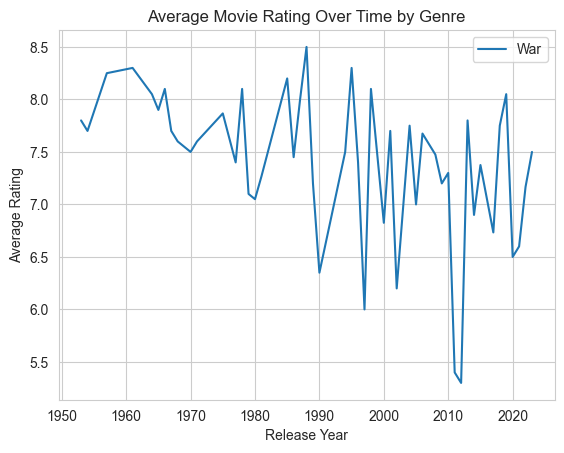

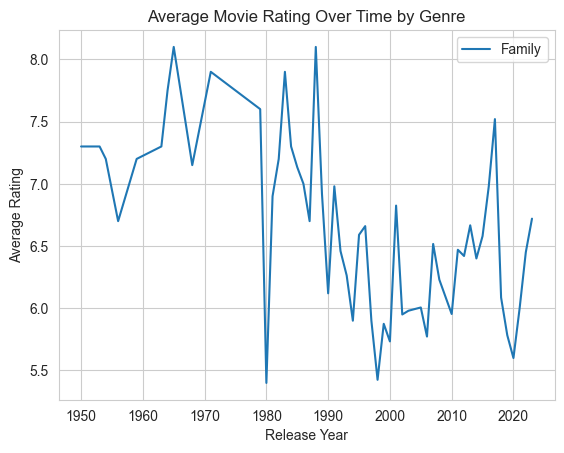

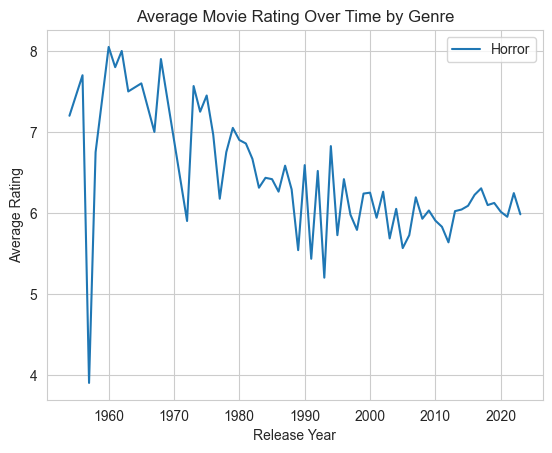

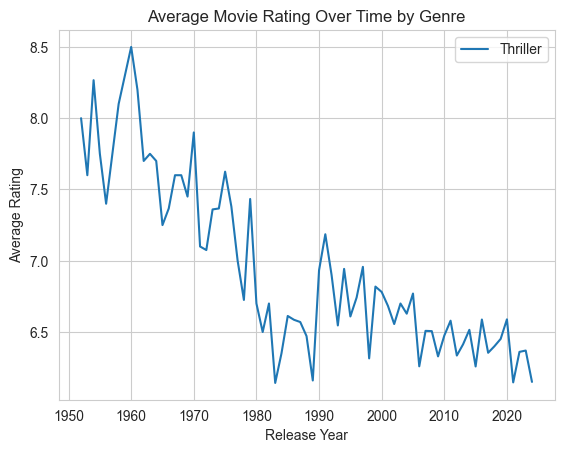

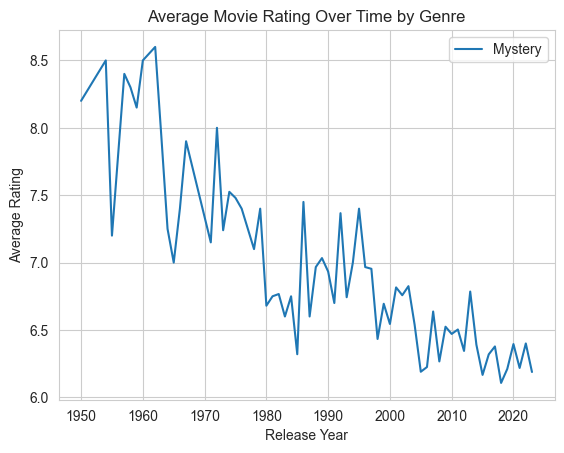

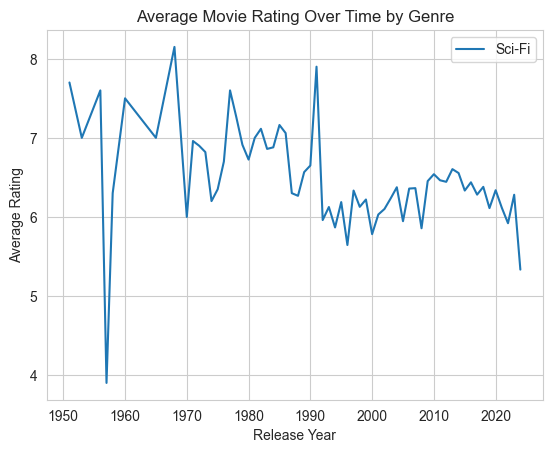

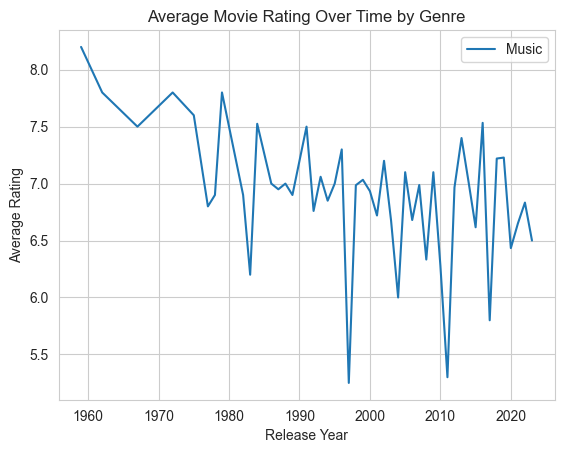

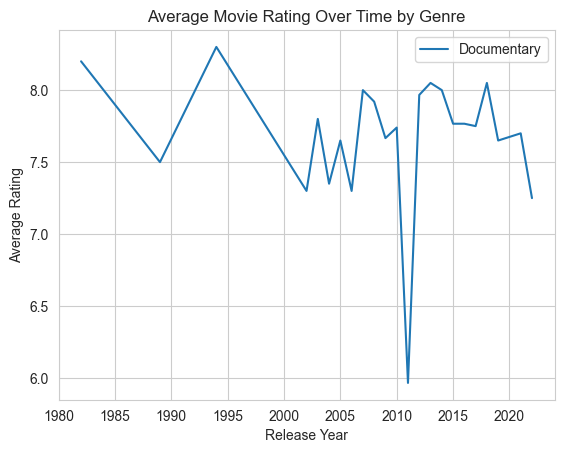

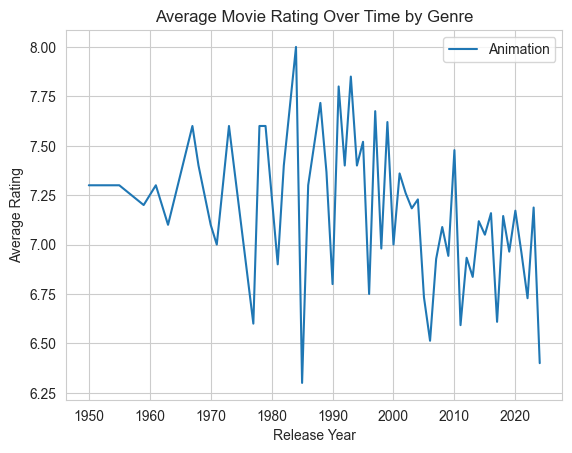

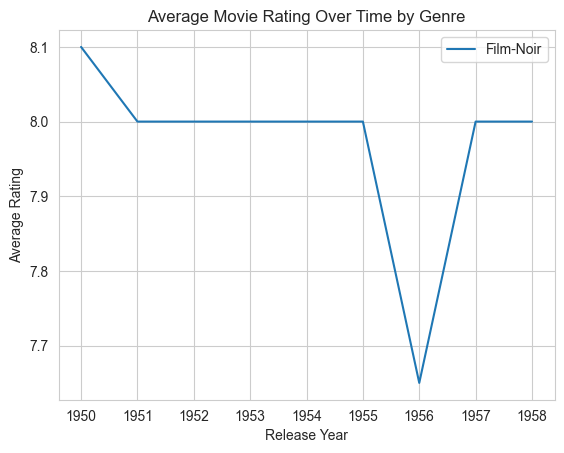

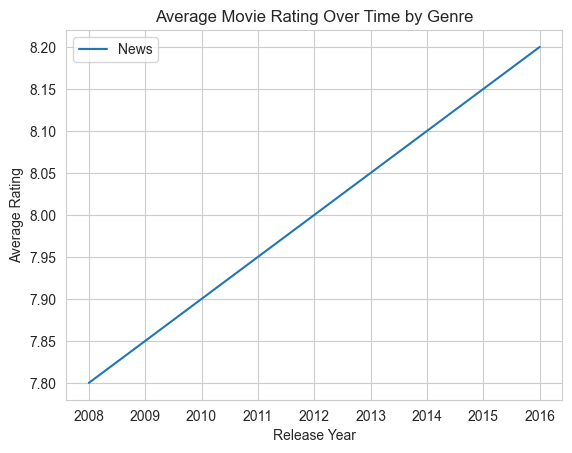

In [42]:
for genre in genres_list:
    temp_df = df_genres.copy()
    temp_df = temp_df[temp_df['Genre'] == genre].sort_values(by=['Rating'])
    
    df_avg_ratings = temp_df.groupby(['Release Year'])['Rating'].mean().reset_index()
    
    plt.plot(df_avg_ratings['Release Year'], df_avg_ratings['Rating'], label=genre)

    plt.xlabel('Release Year')
    plt.ylabel('Average Rating')
    plt.title('Average Movie Rating Over Time by Genre')
    plt.legend()
    plt.show()

    plt.show()
        

## Normalizing the data:

In [66]:
from sklearn.preprocessing import MinMaxScaler

numeric_columns = df.select_dtypes(include=['int', 'float'])
print(numeric_columns.head().columns)
df[numeric_columns.columns] =  MinMaxScaler().fit_transform(numeric_columns)

numeric_columns = df[numeric_columns.columns]

Index(['Release Year', 'Duration', 'Rating', 'Number of Votes', 'Meta Score',
       'Budget', 'Gross (worldwide)', 'profit'],
      dtype='object')


<Figure size 1000x1000 with 0 Axes>

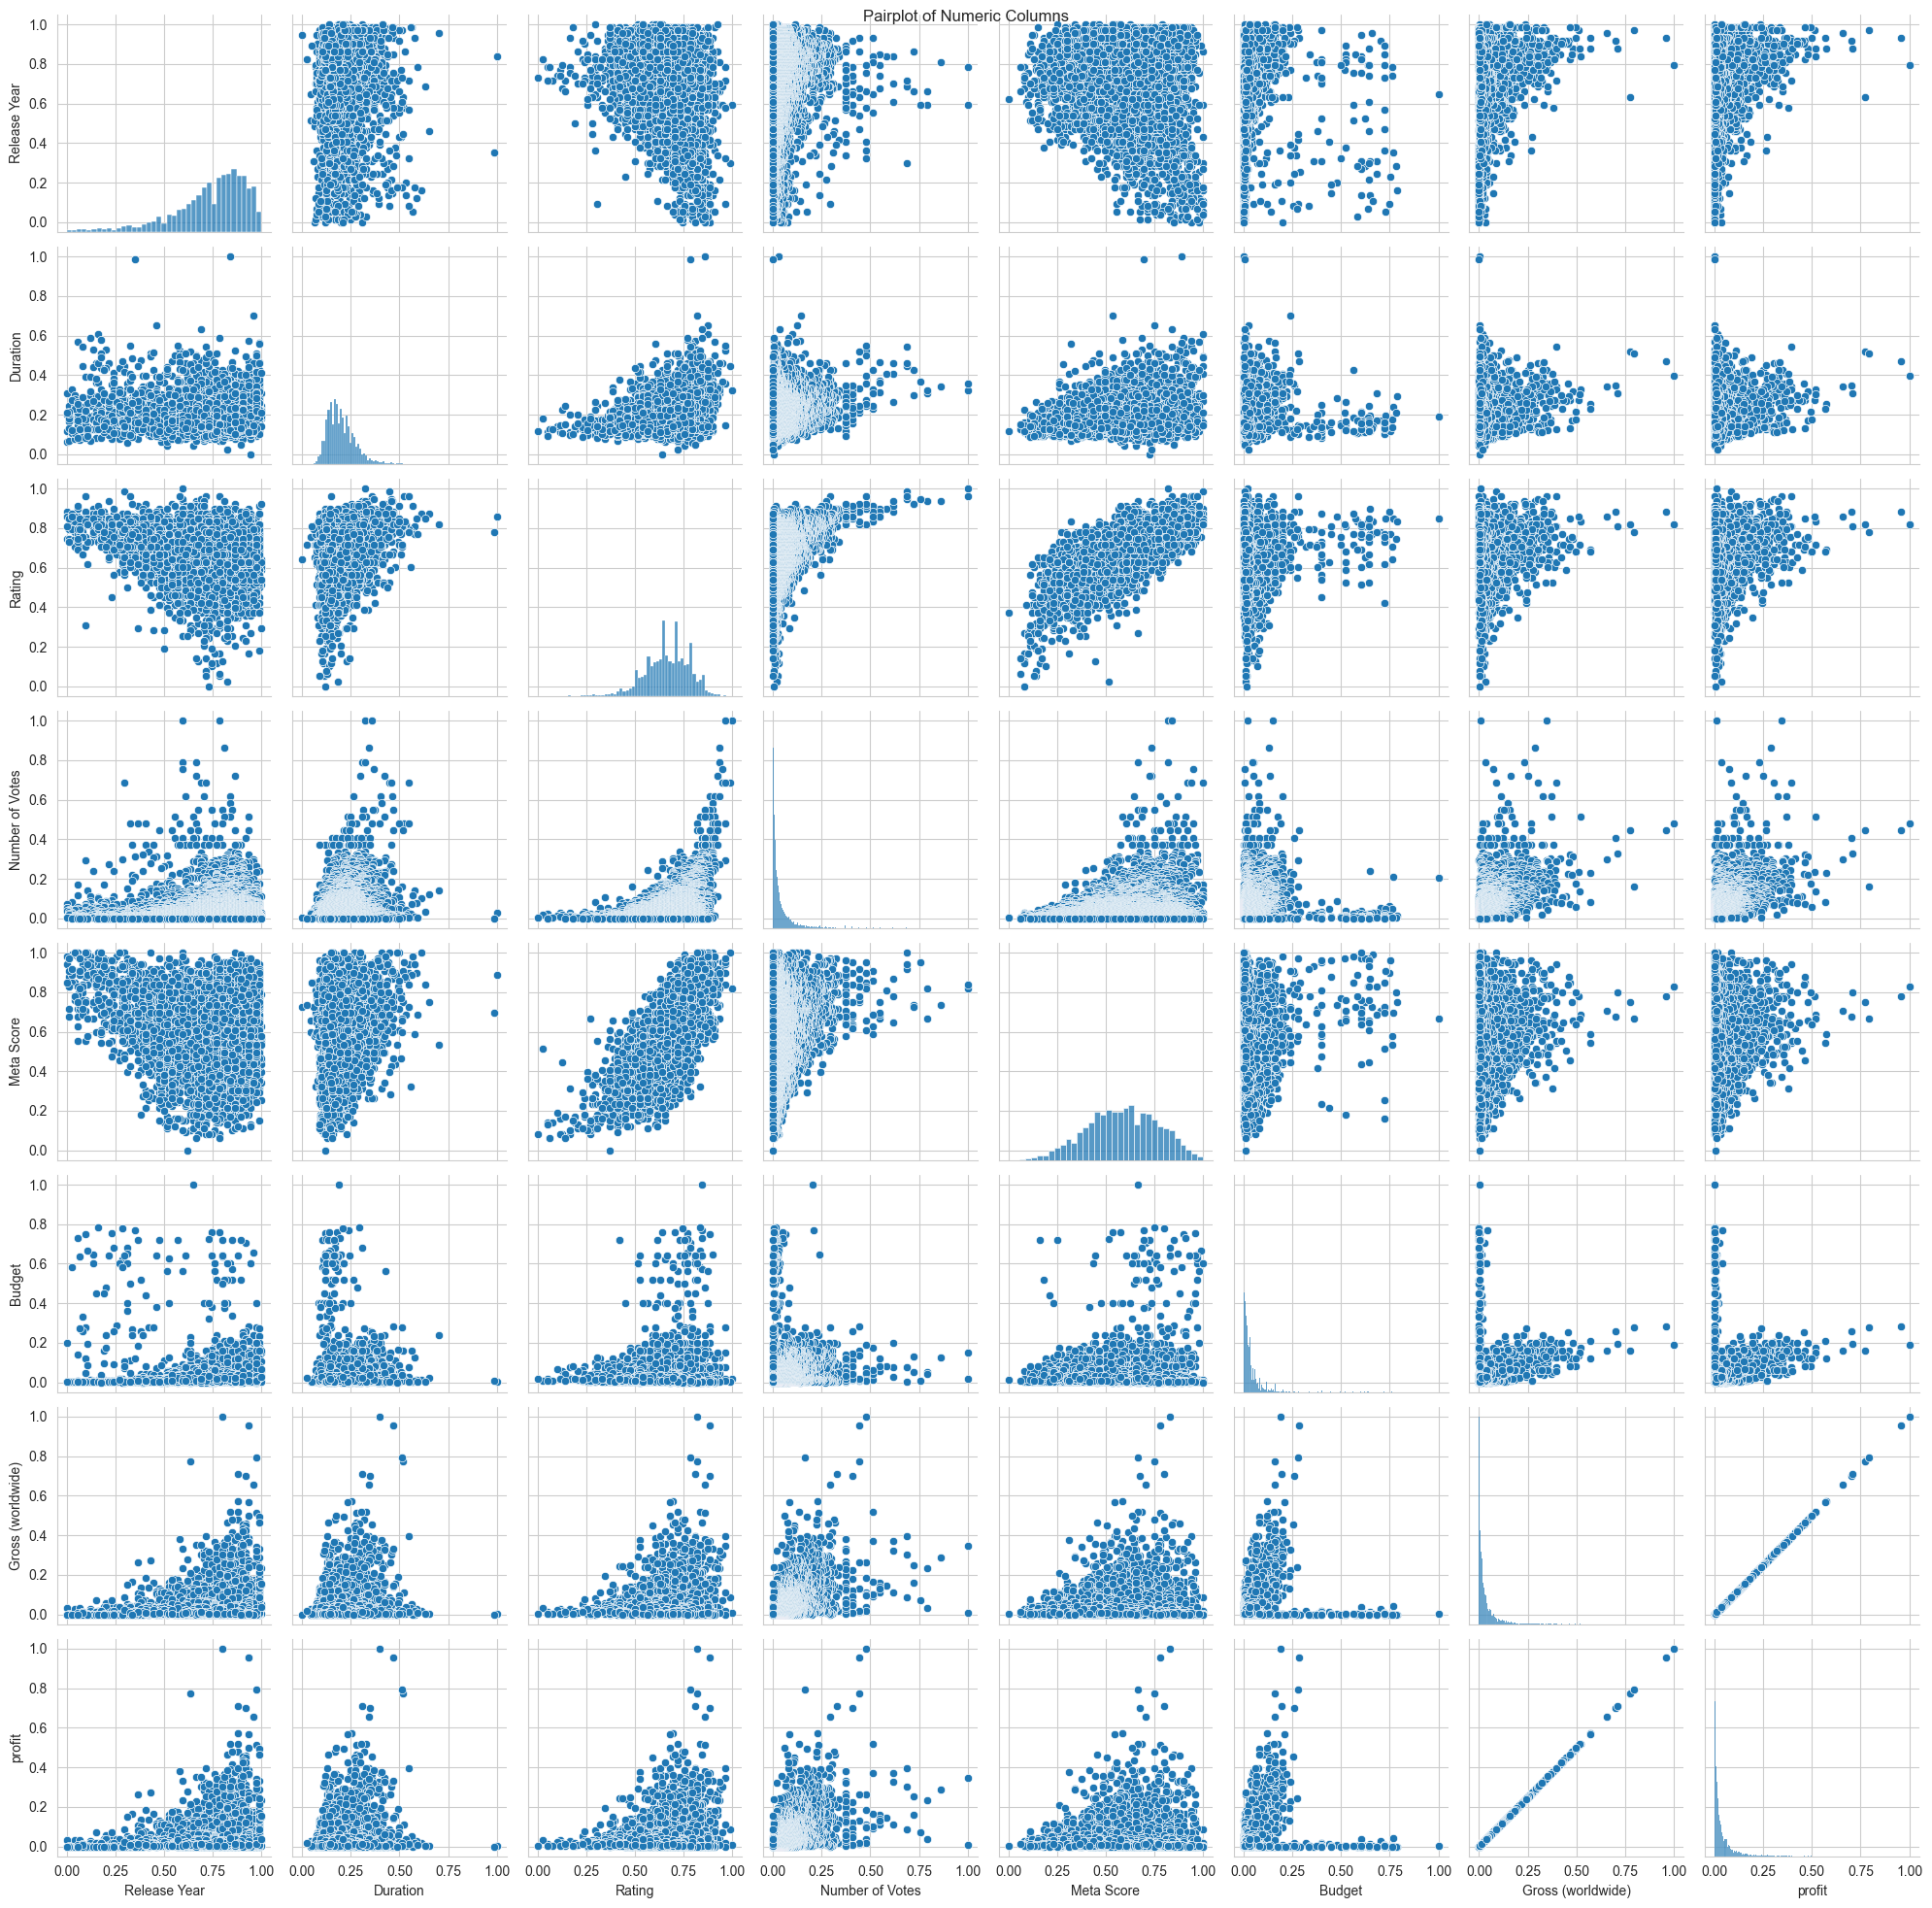

In [67]:
plt.figure(figsize=(10, 10))
sns.pairplot(data=numeric_columns)
plt.suptitle('Pairplot of Numeric Columns')
plt.tight_layout()
plt.show()



In the past, most people who voted for movies tended to give higher ratings. As the years have passed, we observe that ratings have become more spread out, with lower ratings also becoming more common.

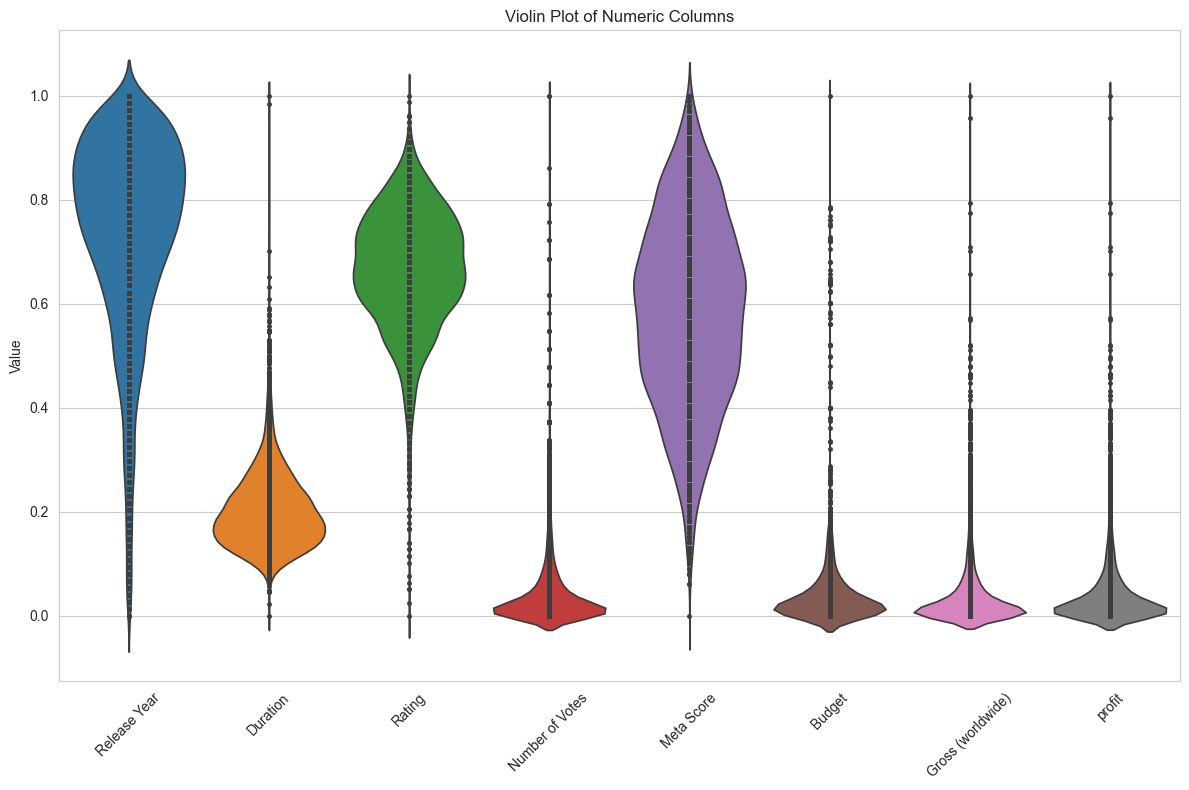

In [68]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=numeric_columns, orient='v', inner='point')
plt.title('Violin Plot of Numeric Columns')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Genres over time